In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# 데이터셋 불러오기
df = pd.read_csv('dataset.csv', index_col=0)

# 'Result' 열은 phishing/legitimate 데이터를 가지고 있음
X = df.drop(columns=['Result'])
y = df['Result']

# 클래스 값을 [-1, 1]에서 [0, 1]로 변환 (필요한 경우)
y = y.replace(-1, 0)

In [3]:
# 데이터셋을 훈련/테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 1. RandomForest 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [5]:
# 2. XGBoost 모델 학습
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:32:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [6]:
# 3. LightGBM 모델 학습
lgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4902, number of negative: 3942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 8844, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554274 -> initscore=0.217955
[LightGBM] [Info] Start training from score 0.217955


LGBMClassifier(random_state=42)

In [7]:
# 모델별 피처 중요도를 데이터프레임으로 변환
# RandomForest
rf_importance_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf.feature_importances_
})

In [8]:
# XGBoost
xgb_importance_df = pd.DataFrame({
    'feature': X.columns,
    'xgb_importance': xgb_model.feature_importances_
})

In [9]:
# LightGBM
lgbm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'lgbm_importance': lgbm.feature_importances_
})

In [10]:
# 데이터프레임 병합 (feature 열을 기준으로)
importance_df = rf_importance_df.merge(xgb_importance_df, on='feature').merge(lgbm_importance_df, on='feature')

# 중요도 정규화 (합이 1이 되도록)
importance_df['rf_importance'] = importance_df['rf_importance'] / importance_df['rf_importance'].sum()
importance_df['xgb_importance'] = importance_df['xgb_importance'] / importance_df['xgb_importance'].sum()
importance_df['lgbm_importance'] = importance_df['lgbm_importance'] / importance_df['lgbm_importance'].sum()

# 가중 평균을 사용해 최종 중요도 계산 (가중치를 동일하게 1/3로 설정)
importance_df['weighted_importance'] = (
    importance_df['rf_importance'] * 1/3 +
    importance_df['xgb_importance'] * 1/3 +
    importance_df['lgbm_importance'] * 1/3
)

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='weighted_importance', ascending=False)

In [11]:
# 결과 출력
print(importance_df[['feature', 'weighted_importance']])

                        feature  weighted_importance
7                SSLfinal_State             0.268342
13                URL_of_Anchor             0.161403
5                 Prefix_Suffix             0.065333
25                  web_traffic             0.058344
6             having_Sub_Domain             0.054010
14                Links_in_tags             0.044700
28       Links_pointing_to_page             0.032663
12                  Request_URL             0.027080
15                          SFH             0.026977
24                    DNSRecord             0.023260
0    having_IPhaving_IP_Address             0.022459
23                age_of_domain             0.022222
27                 Google_Index             0.020876
26                    Page_Rank             0.018929
8   Domain_registeration_length             0.017849
1                 URLURL_Length             0.016488
11                  HTTPS_token             0.013155
16          Submitting_to_email             0.

<ipython-input-12-7c945a2a8d01>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_importance', y='feature', data=importance_df, palette='viridis')


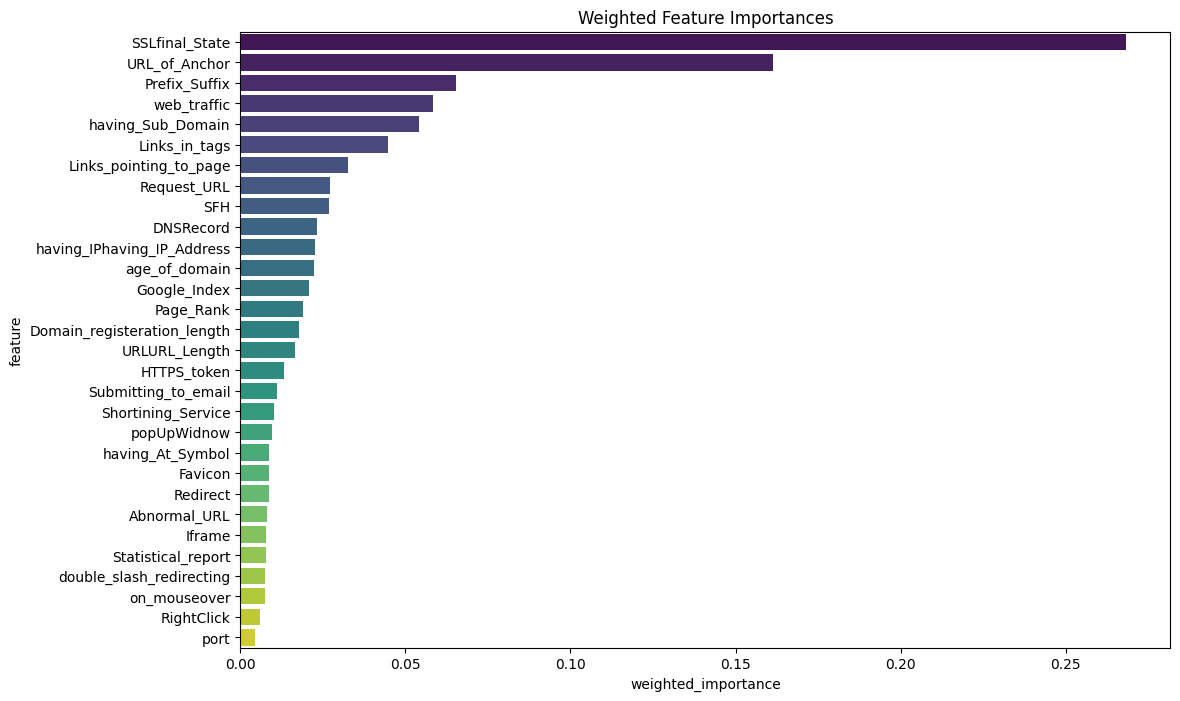

In [12]:
# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='weighted_importance', y='feature', data=importance_df, palette='viridis')
plt.title('Weighted Feature Importances')
plt.show()